# Domain-specific task: classifying polymers # 

In this exercise, you are tasked with performing k-means clustering on dataset of polymer properties. This exercise should give you a practical understanding of how to implement k-means as well as exposure to one flavor of the many kinds of tasks you will be asked to perform in internship settings. It is important to have an appreciation for the "big picture" when it come to data science and what you are actually trying to achieve, regardless of domain.

<ins>Motivation</ins>: You are working for a materials supplier and your boss needs to know what kind of polymer will work best in a given situation (maybe for a playground slide). It is important that the polymer of choice withstand high temperatures without deforming easily under pressure. A material's ability to resist deformation is measured by its Elastic and Shear Moduli (Elastic being relevant in settings of tension, Shear being relevant in settings of torsion or shearing). Shearing will be important here given the way that children will use the slide. Polymers also contain a specific material property known as the Glass Transition Temperature. This temperature determines the limit at which the polymer's stiffness (or, ability to resist deformation) breaks down. You know that polymers can typically be described by three categories, delineated most clearly by their degree of cross-linking (i.e. the density of chemical bonds between adjacent molecular polymer strands) and their ability to deform without permament damage:

<ul>    
<li>Thermosets (high cross-linking, high resistance to deformation)</li>
<li>Thermoplastics (no cross-linking, moderate resistance to deformation)</li>
<li>Elastomers (low to moderate cross-linking, low resistance to deformation, but no permanent deformation)</li>
    
</ul>

Note that polymers are usually not easily binned into these three categories in the real world since they can often exhibit characteristics of two or all three types.

<ins>Task</ins>: Your advisor has a dataset of polymers, but they do not have the names of these polymers or their types (this might be a common case if the materials developed are highly secretive). The dataset includes the values of their shear moduli, glass transition temperature, density, the precision of the density measurements, and 3 categorical variables: (1) whether the polymer melts or burns (a distinguishing factor for thermosets is that they burn rather than melt), (2) the degree of cross-linking (thermoplastics have no cross-linking, elastomers have low to moderate, and thermosets have high cross-linking), and (3) the degree of elongation (i.e. how far the material can be stretched before deforming permanently). With only this dataset, use k-means to systematically separate the data points into some optimal number of distinct clusters.

Run each of the cells below, adding in your own code where required. Write down your answers/comments for the following short answer questions, as well. 

## Step 1: Data visualization ##

Let's take a look at the dataset your boss gave you:

In [114]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [130]:
polymers_df = pd.read_csv("./PolymersData_NoLabels.csv")

In [131]:
polymers_df.head()

,Glass Transition Temperature (K),Shear Modulus (MPa),Density (g/cm^3),Density Measurement Precision (no. sig figs),Melt or Burn?,Level of Cross-Linking,Elongation
0,476,1278.8,1.200,2,melt,none,moderate
1,437,1599.1,1.200,2,burn,high,low
2,431,2391.3,0.936,3,melt,none,moderate
3,390,1045.7,1.050,3,melt,none,moderate
4,387,1222.9,2.000,1,burn,high,low


Below are a could of helper functions which we will use throughout. Let's plot the shear modulus against the glass transition temperature.

In [132]:
def plot_data(df, x, y, hue=None, logscale=False):
    sns.set_style('whitegrid')
    fig = sns.lmplot(x=x, y=y, 
               data=df, hue=hue, palette='coolwarm',
               height=6, aspect=1, fit_reg=False)

    ax = fig.axes[0][0]
    if logscale:
        ax.set_yscale('log')
    return

def df2np(df, xs):
    X = df[xs].to_numpy()
    return X

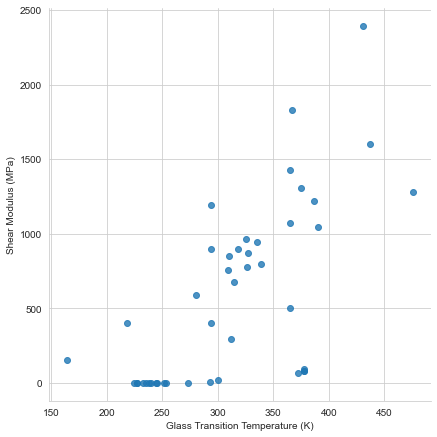

In [133]:
plot_data(df=polymers_df, 
          x='Glass Transition Temperature (K)', 
          y='Shear Modulus (MPa)',
          logscale=False)

This does not give us much intuition in terms of separating data points. However, it looks like there are a group of points clustered at very low shear moduli. Let's try to plot the shear modulus on a log scale:

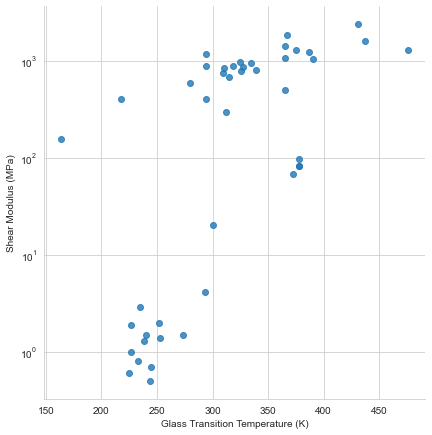

In [134]:
plot_data(df=polymers_df, 
          x='Glass Transition Temperature (K)', 
          y='Shear Modulus (MPa)',
          logscale=True)

Now we are starting to see some significance in the separation between the data points. There are still several features which we have not utilized, though. Use the 'plot_data' helper function to produce two other plots and visualize the Glass Transition Temperature as well as the Shear Modulus against the Density. Do you see any significant clusters in the data? (Remember you can plot on a log scale if you think that will help illuminate any trends better).  

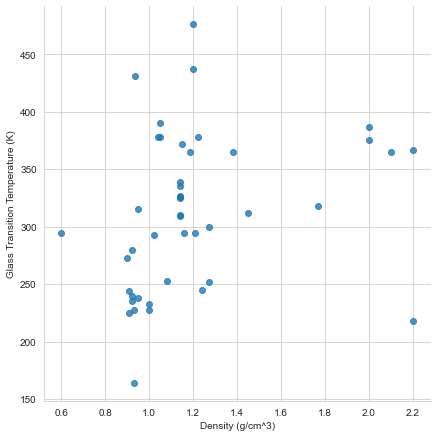

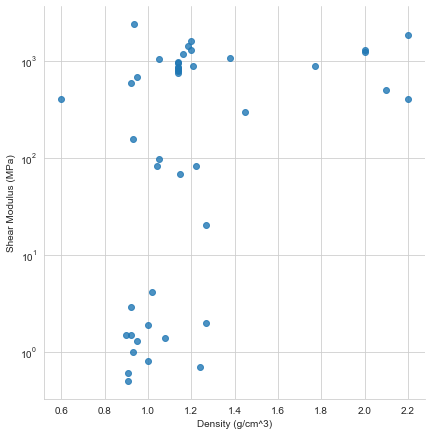

In [138]:
# TODO: use plot_data to plot the remaining numerical features
# from the dataset 
#### start_plotting ####
plot_data(df=polymers_df, 
          x='Density (g/cm^3)', 
          y='Glass Transition Temperature (K)',
          logscale=False)
plot_data(df=polymers_df, 
          x='Density (g/cm^3)', 
          y='Shear Modulus (MPa)',
          logscale=True)
#### end_plotting ####

__Comment on the visualizations above. Is it easy to isolate any clusters from one another? What features have we not looked at yet?__

#### Start Comments ####

Any observation will suffice for this questions. We could potentially see a cluster at the bottom of the Shear Modulus and Density plot and one near the top. We could still include information from the categorical features: melt or burn, level of cross-linking, and elongation. 

#### End Comments ####

Let's use PCA to reduce the dimensionality of the dataset and to utilize all of the remaining features. We have mapped the categorical data to numerical values. With this new dataframe, we can use PCA to reduce the dimensionality of the dataset and hopefully isolate all of the datapoints into regions of high similarity. Run the cell below to see this visualized. 

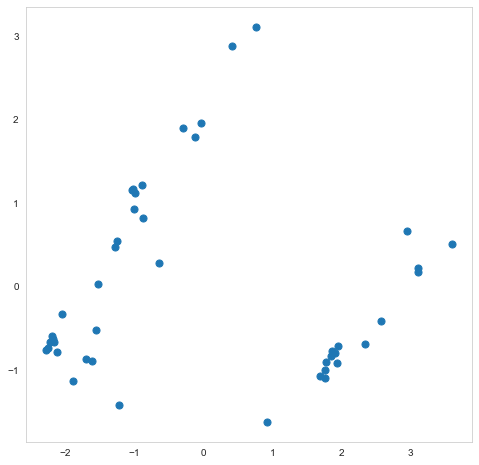

In [139]:
def implement_pca(x):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents,
                               columns = ['principal component 1', 'principal component 2'])
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], s=50)
    ax.grid()
    return principalDf

cat2num = {'Melt or Burn?' : {'melt' : 0, 'burn' : 1},
           'Level of Cross-Linking' : {'none' : 0, 'low' : 1, 'moderate' : 2, 'high' : 3},
           'Elongation' : {'low' : 0, 'moderate' : 1, 'high' : 2}}


polymers_df_norm = polymers_df.replace(cat2num)
x = polymers_df_norm.loc[:, features].values
x = StandardScaler().fit_transform(x)
features = ['Glass Transition Temperature (K)', 'Shear Modulus (MPa)', 'Density (g/cm^3)', 'Level of Cross-Linking', 'Melt or Burn?', 'Elongation']
principalDf = implement_pca(x)

Now, we'll map this dataframe to a numpy array for ease of computation for the remainder of the notebook. Run the cell below before moving onto the next part. 

In [140]:
X = df2np(df=principalDf, xs=['principal component 1', 'principal component 2'])

## Step 2: k-Means Implementation

Let $X$ denote the set of $N$ data points $\vec{x_i} \in \mathbb{R}^d$. A cluster assignment is a partition $C_1, ..., C_k \in X$ such that the sets $C_k$ are disjoint and $X = C_1 \cup ... \cup C_k$. A data point $\vec{x_i} \in X$ is said to belong to cluster $k$ if it is in $C_k$.

Formally, k-Means solves the following optimization problem: $\underset{\{C_k\}_{k = 1}^{K}, \{\vec{c_k}\}_{k = 1}^{K}: X = C_1 \cup ... \cup C_K}{\arg\min} \sum_{k = 1}^{K} \underset{\vec{x} \in C_k}{\sum} \|\vec{x} - \vec{c_k}\|^2$ 

More informally, k-Means is trying to find the best cluster centers & assignments that maximize the distance between clusters and minimize the size of each cluster. In other words, we want to find clusters that are as far apart (distinct) from each other as possible, while making sure that all the points in a cluster are pretty close to each other. 

Solving this optimization problem directly is NP-hard (i.e. computationally very difficult). Instead, we use Lloyd's Algorithm: 
1. Pick some K representing the number of groups you wish to cluster your datset into
2. Randomly initialize $\vec{c_k}, k = 1,...,K$
3. While $\vec{c_k}$ keeps changing (k-Means has not converged): 
    * Update partition $C_1 \cup ... \cup C_k$ given by the $\vec{c_k}$ by assigning each $\vec{x_i} \in X$ to the cluster represented by its nearest centroid: $\underset{k}{\arg\min} \|\vec{x} - \vec{c_k}\|^2$
    * Update centroid $\vec{c_k}$ given $C_1 \cup ... \cup C_k$ as $\vec{c_k} = \frac{1}{\lvert {C_k} \rvert} \sum_{\vec{x} \in C_k} \vec{x}$

This algorithm will always converge to some value because each step in (3) is guaranteed to not increase the value of the objective function. This two-step algorithm can be implemented using the help of two functions: 
1. assign_clusters: given a set of clusters, assign each data point to the best cluster
2. update_means: given a set of cluster assignments, compute the new best cluster center (a.k.a. centroid)

#### TODO: complete the implementations of assign_clusters and update_means below

In [48]:
def assign_clusters(X, c): 
    """
    Takes in an (n x d) data matrix X, and a (k x d) matrix of the centroids c. 
    Returns a length-n vector with the index of the closest centroid to each data point.
    """
    n, d = X.shape
    k = c.shape[0]
    assert d == c.shape[1], "Centroids are of the wrong shape"
    assignments = np.zeros(n)
    for i, point in enumerate(X): 
        #TODO: Set assignments[i] to be the index of the centroid who is closest to the current point
        ### start assign_cluster ###
        ############################
        assignments[i] = min(range(k), key = lambda j: np.linalg.norm(point - c[j]))
        ###########################
        ### end assign_cluster ###
    return assignments

def update_means(X, assignments): 
    """
    Takes in an (n x d) data matrix X, and a length-n vector of
    the cluster indices of each point.
    Computes the mean of each cluster and returns a (k x d) matrix of the centroids.
    """
    n, d = X.shape
    assert len(assignments) == n
    k = len(set(assignments))
    centroids = []
    for i in range(k): 
        #TODO: set centroid_i to be the mean of all points in cluster 'i'
        ### start update_means ###
        cluster_points = X[assignments == i]
        centroid_i = np.mean(cluster_points, axis = 0)
        ### end update_means ###
        centroids.append(centroid_i)
    return np.array(centroids)

Along with assign_clusters and update_means, we need a few other helper functions to have a working k-Means implementation: 
1. initialize_centroids: this will randomly pick k number of data points to serve as the initial centroids to pass into assign_clusters to kickstart the algorithm. 
2. cost: unlike supervised learning problems where we can measure training error by calculating the distance between our model output and the true output, unsupervised learning does not have the same luxury. We actually don't have access to the true clusters that the data points belong to, so we have to come up with a different measure of how well or poor our clustering is. For this demo, we will use the summ of squared distance of each data point to its centroid as a measure of cost. 

#### TODO: Complete the implementations of initialize_centroids and cost below

In [49]:
def initialize_centroids(X, k): 
    """
    Takes in an (n x d) data matrix X, and employs forgy initialization, where the initialized centroids are
    randomly chosen from the input data set. 
    """
    n, d = X.shape
    #TODO: Set centroids to be k randomly picked data points from X
    ### start initialize_centroids ###
    ##################################
    np.random.seed(0)
    centroids = X[np.random.choice(n, k, replace = False)]
    ################################
    ### end initialize_centroids ###
    return centroids

def cost(X, assignments, centroids): 
    """
    Computes the sum of the squared distance between each point
    and the mean of its associated cluster. 
    Remember: k-Means seeks to minimize intra-cluster distance 
    and maximize inter-cluster distance.
    """
    total_cost = 0
    n, d = X.shape
    k = centroids.shape[0]
    assert centroids.shape[1] == d
    assert len(assignments) == n
    for i in range(k): 
        #TODO: set cost_i to be the sum of squared distance from all points in cluster 'i' to centroid 'i'
        ### start cost ###
        ##################
        cost_i = np.linalg.norm(X[assignments == i] - centroids[i])**2
        ################
        ### end cost ###
        total_cost += cost_i
    return total_cost

All of these functions together will give us a working k-Means implementation. We've provided a function that will run through Lloyd's algorithm and call each of these functions individualy. We've also included a few more functions that will help us visualize our results. No need to modify any of the functions below. 

In [50]:
def k_means(X, k): 
    """
    Take in an (n x d) data matrix X and a parameter 'k' representing the number of clusters. 
    Yields the centroids and cluster assignments after each step 
    of running k-means in a 2-tuple.
    """
    n, d = X.shape
    centroids = initialize_centroids(X, k)
    assignments = assign_clusters(X, centroids)
    
    steps = []
    
    while True: 
        steps.append((centroids, assignments))
        centroids = update_means(X, assignments)
        new_assignments = assign_clusters(X, centroids)
        if np.all(assignments == new_assignments): 
            steps.append((centroids, assignments))
            error = cost(X, assignments, centroids)
#             print(f'Final cost = {cost(X, assignments, centroids)}')
            break
        assignments = new_assignments
    
    return steps, error

def final_k_means_cluster(X, k): 
    steps, cost = k_means(X, k)
    return steps[-1][0], steps[-1][1], cost

def plot_clustering(X, centroids, assignments): 
    k = len(centroids)
    for j in range(k): 
        plt.scatter(*X[assignments == j].T)
    plt.scatter(*centroids.T, marker='x', s = 240, c = 'black')
    plt.show()

def interact_clustering(X, logger): 
    history = list(logger)
    k = history[0][0].shape[0]
    
    def plotter(i): 
        plot_clustering(X, *history[i])
    
    interact(plotter, i = IntSlider(min=0, max=len(history) - 1, continuous_update = False))

def demo(classes, history= False): 
    for c in classes: 
        plt.scatter(*c.T)
    plt.show()
    
    points = np.vstack(classes)
    
    if history: 
        interact_clustering(points, k_means_cluster(points, len(classes)))
    else: 
        centroids, assignments = final_k_means_cluster(points, len(classes))
        plot_clustering(points, centroids, assignments)

Before we can continue, we should make sure that our implementation is working properly. Let's compare the results of our k-Means implementation with Sklearn's implementation on our dataset X projected onto its first 2 principal components. This way, we can actually visualize the clusters in 2D space. If we were to work with the raw dataset in dimensions greater than 3, we couldn't visualize the clusters & would have to rely on our measure of cost to determine how effective the clusters were. 

#### TODO: Referencing the documentation for the sklearn implementation of K-Means, fill in the necessary code into the following helper function

In [92]:
def package_implementation(X, k):
    """
    Takes in an (n x d) matrix X and a parameter 'k' representing the number of clusters. 
    Returns the final (centroid, assignments) tuple.
    """
    #TODO: set the centroids, assignments and cost variables of the function
    kmeans = KMeans(n_clusters=k, n_init=1, init=initialize_centroids(X, k)).fit(X)
    ### start package_implementation ###
    ####################################
    assignments = kmeans.labels_
    centroids = kmeans.cluster_centers_
    cost = kmeans.inertia_
    ##################################
    ### end package_implementation ###
    
    return (centroids, assignments, cost)

19.413469294094273


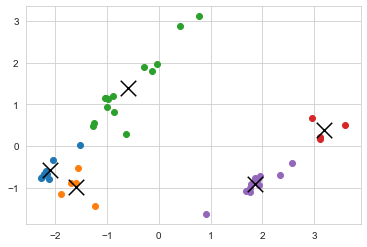

In [93]:
centroids, assignments, total_distance_cost = final_k_means_cluster(X, k=5)
print(total_distance_cost)
plot_clustering(X, centroids, assignments)

19.41346929409427


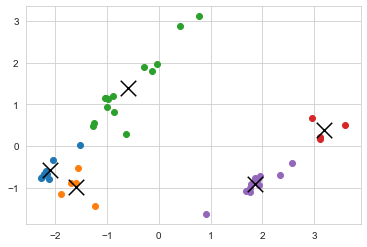

In [94]:
centroids, assignments, total_distance_cost = package_implementation(X, k=5)
print(total_distance_cost)
plot_clustering(X, centroids, assignments)

Did your prediction match the results of the demo? Why or why not? 
#### Start Comments ####

Yes, the predictions match because we ensure that both K-Means implementations are seeded with the right randomization to return the same initial centroids. The rest of the algorithm should be exactly the same between the two implementations. 

#### End Comments ####

## Step 3: Tuning our k-Means Implementation

There are many things we could do to adjust our k-Means implementation to get different clustering results. We'll focus on two different tactics for finding the best parameters to feed into our k-Means implementation: 
1. The number of clusters, K: this will determine how many classes we're left with after our data is clustered. Traditionally, this is either picked using domain knowledge, cross-validation, or a little bit of both. 
2. The dimensionality of data: we can choose to either pass in the raw data, or we can reduce the dimensions of the data. Sometimes, reducing the dimensionality can yield much better clusters because we're only concerning ourselves with the most important components of the data. We saw earlier that projecting the data onto its first two principal components made the data visualization look really different. We can see how clustering might change if we change the number of principal components we project onto. 

Let's explore a how changing the target number of clusters would change the outcome of our implementation. 

What range for K would be appropriate for this hyperparameter tuning task? 

#### Start Answer ####

There is no correct interpretation here, but a sample answer might be: K → [2, 10].

#### End Answer ####

A good sanity check would be to look at the clusters created for different values of k.

#### TODO: change num_clusters to visualize the output of k-Means for different values of k when projecting onto d=2 dimensions.

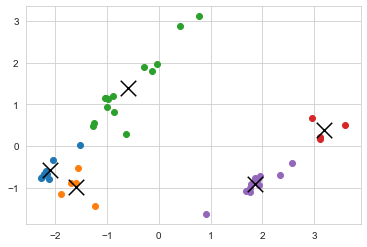

In [95]:
num_clusters = 5
centroids, assignments, total_distance_cost = final_k_means_cluster(X, k=num_clusters)
plot_clustering(X, centroids, assignments)

In many cases, the number of dimensions, d, would be another tuneable hyperparameter. However, we can't perform the same sanity check to look at which projections give us the best clusters because we can't visualize dimensions beyond 3D. Typically, in practice, it's difficult to determine which dimension to project the data into and many data scientists often do this by trial and error. For the purposes of our project, your boss tells you to work in 3 dimensions so that you can easily visualize the different clusters that form. 

#### TODO: pick values for max_k.

In [96]:
max_k = 10
prospective_k = range(1, max_k + 1)

d = 3

In [97]:
def perform_k_means(k, d, X): 
    pca = PCA(n_components=d)
    principalComponents = pca.fit_transform(X)
    return final_k_means_cluster(principalComponents, k=k)

def plot_clustering_d(X, d, centroids, assignments): 
    pca = PCA(n_components=d)
    principalComponents = pca.fit_transform(X)
    k = len(centroids)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for j in range(k): 
        ax.scatter(*principalComponents[assignments == j].T)
    ax.scatter(*centroids.T, marker='x', s = 240, c = 'black')
    plt.show()
    

def validation(arr_k, d, X): 
    all_centroids = []
    all_assignments = []
    all_costs = np.zeros((len(arr_k)))
    for i in range(0, len(arr_k)): 
        centroids, assignments, total_distance_cost = perform_k_means(arr_k[i], d, X)
        all_centroids.append(centroids)
        all_assignments.append(assignments)
        all_costs[i] = total_distance_cost
    
    return all_costs, all_centroids, all_assignments
    

In [98]:
costs, centroids, assignments = validation(prospective_k, d, x)

Typically, when we pick hyperparameters in supervised learning problems, we would separate our dataset into training & validation sets, then test the model created from the training set with different hyperparameters on the validation set. We expect to see a parabola-shaped validation error graph and we pick the hyperparameters that minimize this graph. However, this is not possible with an unsupervised learning problem like K-Means because we do not have any ground truth labels to compare against. Instead, our cost function will always decline as the number of clusters increases because more clusters will always decrease the distance from a data point to its nearest cluster. Therefore, to prevent overfitting to the dataset, data scientists will typically choose the cluster number at the "elbow" of the cost graph. The elbow method is a heuristic used to pick the best cluster size to choose a point where the diminishing returns of more clusters are no longer worth the additional cost. 

#### TODO: Plot the costs against all the prospective k values

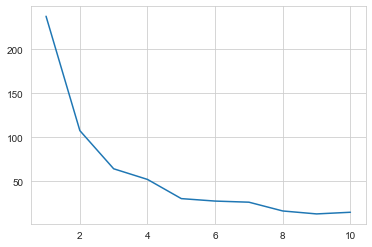

In [99]:
plt.plot(prospective_k, costs)

Based on the results above, what is the optimal value of k? Also, report the min and max costs of clustering. 

#### Start Answer ####

The optimal value of k looks to be close to 4, which represents the elbow of the graph. The min cost of 13.094 is at k = 9, and the max cost of 237.455 is at k = 1. 

#### End Answer ####

You take your findings to your boss. They tell you they just received more information about the polymers contained in the dataset you've been working with. The polymers are guaranteed to fall into 3 different categories: thermosets, thermoplastics, and elastomers. Based on this information, does your choice of the number of clusters change? 

#### Start Answer ####

Yes, based on the domain knowledge provided, we can conclude that the true number of clusters is 3.

#### End Answer ####

You can visualize the reduced data with the confirmed number of cluster assignments below in 3 dimensions. If you would like to interact with the 3D plot, feel free to uncomment the relevant line below

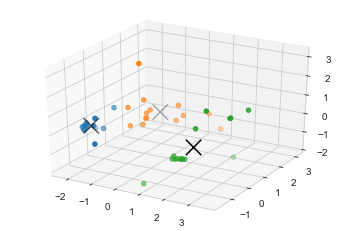

In [100]:
#TODO: Fill in the value for best_k to visualize the clustering.
# %matplotlib qt UNCOMMENT THIS LINE TO INTERACT WITH THE 3-D GRAPH (zoom in/out, rotate, etc)
best_k = 3
plot_clustering_d(x, 3, centroids[best_k-1], assignments[best_k-1])

Congratulations! You've made it to the end of Part 1 of the project. This notebook was intended to help you understand how K-Means would be implemented in an industry setting from end-to-end: 
1. Loading & cleaning the dataset
2. Visualizing the data
3. Implementing K-Means
4. Tuning the hyperparameters associated with the clustering model. 

Now, please move on to Part 2 of the project where you will get to explore the ins and outs of K-Means more in-depth with some toy examples. 